# Netflix Recommendation System

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import sigmoid_kernel
import plotly.express as px
from autoviz.AutoViz_Class import AutoViz_Class
import matplotlib.pyplot as plt

%matplotlib inline


In [46]:
# Load data

df = pd.read_csv("C:\\Users\\Asus\\Desktop\\Top Mentor\\Mechine Learning xlsx file\\netflix_project_csv\\netflix_titles.csv", encoding='latin1')


In [48]:
df

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thabang Molaba, Dillon Windvogel, Natasha Thahane, Arno Greeff, Xolile Tshabalala, Getmore Sithole, Cindy Mahlangu, Ryle De Morny, Greteli Fincham, Sello Maake Ka-Ncube, Odwa Gwanya, Mekaila Mathys, Sandi Schultz, Duane Williams, Shamilla Miller, Patrick Mofokeng",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town teen sets out to prove whether a private-school swimming star is her sister who was abducted at birth.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabiha Akkari, Sofia Lesaffre, Salim Kechiouche, Noureddine Farihi, Geert Van Rampelberg, Bakary Diombera",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Action & Adventure","To protect his family from a powerful drug lord, skilled thief Mehdi and his expert team of robbers are pulled into a violent and deadly turf war.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down among the incarcerated women at the Orleans Justice Center in New Orleans on this gritty reality series.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam Khan, Ahsaas Channa, Revathi Pillai, Urvi Singh, Arun Kumar",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV Comedies","In a city of coaching centers known to train Indiaâs finest collegiate minds, an earnest but unexceptional student and his friends navigate campus life.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, Abigail Breslin, Amber Heard, Bill Murray, Derek Graf",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies","Looking to survive in a world taken over by zombies, a dorky college student teams with an urban roughneck and a pair of grifter sisters.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Mara, Ryan Newman, Michael Cassidy, Spencer Breslin, Rip Torn, Kevin Zegers",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero must train a new crop of youthful saviors when the military preps for an attack by a familiar villain.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8806,s8807,Movie,Zubaan,Mozez Singh,"Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanana, Manish Chaudhary, Meghna Malik, Malkeet Rauni, Anita Shabdish, Chittaranjan Tripathy",India,"March 2, 2019",2015,TV-14,111 min,"Dramas, International Movies, Music & Musicals","A scrappy but poor boy worms his way into a tycoon's dysfunctional family, while facing his fear of music and the truth about his past.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8807,s8808,TV Show,Parasyte: The Grey,Yeon S

In [50]:
# Handle unnamed columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [52]:
# Display initial information
print("Data Shape:", df.shape)


Data Shape: (8809, 12)


In [54]:
print("Data Info:")
df.info()


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8809 entries, 0 to 8808
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8809 non-null   object
 1   type          8809 non-null   object
 2   title         8809 non-null   object
 3   director      6175 non-null   object
 4   cast          7984 non-null   object
 5   country       7978 non-null   object
 6   date_added    8799 non-null   object
 7   release_year  8809 non-null   int64 
 8   rating        8805 non-null   object
 9   duration      8806 non-null   object
 10  listed_in     8809 non-null   object
 11  description   8809 non-null   object
dtypes: int64(1), object(11)
memory usage: 826.0+ KB


In [56]:
# Handle missing values
print("Missing Values Before Cleaning:")
print(df.isnull().sum())

Missing Values Before Cleaning:
show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64


In [58]:
df.nunique()

show_id         8809
type               2
title           8806
director        4529
cast            7694
country          748
date_added      1768
release_year      75
rating            18
duration         220
listed_in        516
description     8777
dtype: int64

In [60]:
# Filling missing 'rating' values
rating_fixes = {
    67: 'TV-PG', 2359: 'TV-14', 3660: 'TV-MA', 3736: 'TV-MA',
    3737: 'NR', 3738: 'TV-MA', 4323: 'TV-MA '
}
for index, rating in rating_fixes.items():
    df.loc[index, 'rating'] = rating

In [62]:
# Clean 'cast' column and fill missing 'country' values
df = df.dropna(subset=['cast'])
df['country'] = df['country'].fillna('United States')

In [64]:
# Verify cleaning
print("Missing Values After Cleaning:")
print(df.isnull().sum())


Missing Values After Cleaning:
show_id            0
type               0
title              0
director        2282
cast               0
country            0
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64


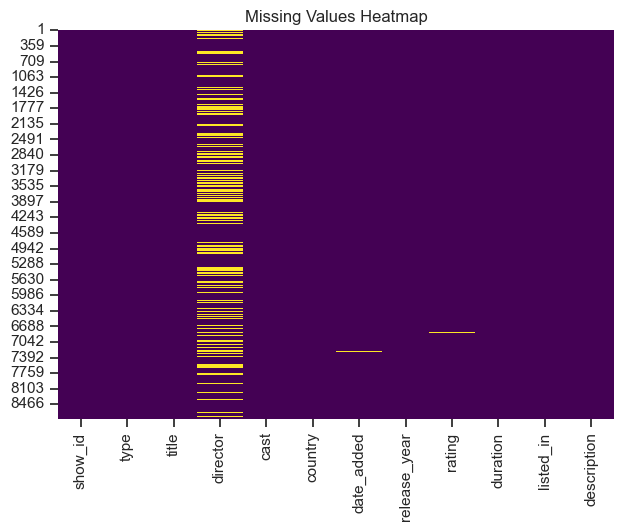

In [66]:
# Visualizations
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

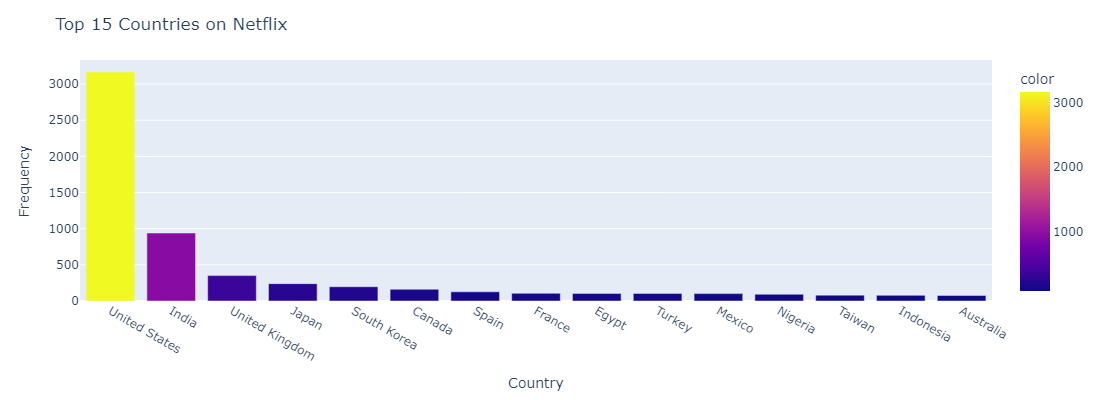

In [67]:
# Visualize top 15 countries
country_counts = df['country'].value_counts().head(15)
fig = px.bar(x=country_counts.index, y=country_counts.values, color=country_counts.values,
             labels={'x': 'Country', 'y': 'Frequency'}, height=400)
fig.update_layout(title="Top 15 Countries on Netflix")
fig.show()

In [70]:
# Prepare for recommendations
tfv = TfidfVectorizer(min_df=3, ngram_range=(1,3), stop_words='english')
df['combined'] = df[['description', 'cast', 'director']].fillna('').agg(' '.join, axis=1)
tfv_matrix = tfv.fit_transform(df['combined'])

In [71]:
# Compute similarity matrix
sig = sigmoid_kernel(tfv_matrix, tfv_matrix)

In [72]:
# Create indices mapping
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

In [74]:
def recommend(title, sig=sig):
    idx = indices.get(title)
    if idx is None:
        return "Title not found in the dataset."
    sig_scores = list(enumerate(sig[idx]))
    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)
    sig_scores = sig_scores[1:11]  # Skip the first one (itself)
    movie_indices = [i[0] for i in sig_scores]
    return df['title'].iloc[movie_indices]

In [78]:
# Test recommendations
print("Recommendations for 'Kota Factory':")
print(recommend("Kota Factory"))

Recommendations for 'Kota Factory':
4115      Ken Jeong: You Complete Me, Ho
1801                       Over the Moon
3016                                 Hop
4386                 The Princess Switch
2656                     The Willoughbys
6355    Bombshell: The Hedy Lamarr Story
5869                          Turbo FAST
565             Bureau of Magical Things
264                        Walk of Shame
1452                       Gimme Shelter
Name: title, dtype: object


In [80]:
print("Recommendations for 'Gargantia on the Verdurous Planet':")
print(recommend('Gargantia on the Verdurous Planet'))

Recommendations for 'Gargantia on the Verdurous Planet':
8114        Sudani from Nigeria
6665    Eddie Murphy: Delirious
1450          Eddie Murphy: Raw
1544                  Grizzlies
8583         Thorne: Sleepyhead
4293    Springsteen on Broadway
3661                      Bogda
7941               Satan & Adam
3762        Designated Survivor
3379                Rattlesnake
Name: title, dtype: object
